In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit
import lmfit

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate, Multiply, Reshape, ActivityRegularization
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

from carl.learning.calibration import HistogramCalibrator, IsotonicCalibrator, SigmoidCalibrator, NDHistogramCalibrator
from carl.distributions.base import weighted_quantile

from awkde import GaussianKDE


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Translation between s and r

In [4]:
def s(r):
    return 1./(1. + r)

def r(s, epsilon=1.e-3):
    return (1.-s)/(s + epsilon)

# Data

In [ ]:
# Benchmark
theta1 = 708
theta = 9
theta_score = 0

#X to take into account
X_indices_import = list(range(42))
n_features = len(X_indices_import)
X_indices = list(range(n_features))

# Data
data_dir = '../data'
figure_dir = '../figures/score_density_estimation'

# Thetas
thetas = np.load(data_dir + '/thetas/thetas_parameterized.npy')
delta_theta = thetas[theta] - thetas[theta_score]
print(delta_theta)

# Training, calibration and test samples
X_train = np.load(data_dir + '/unweighted_events/X_train_scoreregression.npy')
scores_train = np.load(data_dir + '/unweighted_events/scores_train_scoreregression.npy')

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')[::10, X_indices_import]
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')[:,::10]

X_test = np.load(data_dir + '/unweighted_events/X_test.npy')[:,X_indices_import]
scores_test = np.load(data_dir + '/unweighted_events/scores_test.npy')[theta_score]
r_test = np.load(data_dir + '/unweighted_events/r_test.npy')[theta]
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)
X_test_transformed = scaler.transform(X_test)

# keras requires training data with the same output as the NN
scores_gradients_train = np.zeros((scores_train.shape[0], 2 + 2*n_features))
scores_gradients_train[:,:2] = scores_train

# 2d calibration plots
xi = np.linspace(-5.0, 10.0, 200)
yi = np.linspace(-5.0, 10.0, 200)

xx, yy = np.meshgrid(xi, yi)
scores_eval = np.asarray((xx.flatten(), yy.flatten())).T

# 1d calibration curbves
tt_eval = np.linspace(-10.,10.,1000)

In [66]:
# Covariance matrix over a subset of the X for the grad-adaptive approach
cov_X = np.cov(X_train_transformed[::,X_indices], rowvar=False)

# Score regression

In [19]:
def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x

    return f

def hidden_layers(n,
                  hidden_layer_size=100,
                  activation='tanh',
                  dropout_prob=0.0):
    r = []
    for k in range(n):
        if dropout_prob > 0.:
            s = stack_layer([
                Dropout(dropout_prob),
                Dense(hidden_layer_size, activation=activation)
            ])
        else:
            s = stack_layer([Dense(hidden_layer_size, activation=activation)])
        r.append(s)
    return stack_layer(r)

def loss_function_score_regression(y_true, y_pred):
    return losses.mean_squared_error(y_true[:,:2], y_pred[:,:2])

def make_regressor(n_hidden_layers=3,
                    hidden_layer_size=100,
                    activation='tanh',
                    dropout_prob=0.0):
    # Inputs
    input_layer = Input(shape=(42,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    score_layer = Dense(2, activation='linear')(hidden_layer)

    # gradients with respect to x... there must be a nicer way to do this?
    gradient0_layer = Lambda(lambda x: K.gradients(x[0][0], x[1])[0],
                            output_shape=(n_features,))([score_layer, input_layer])
    gradient1_layer = Lambda(lambda x: K.gradients(x[0][1], x[1])[0],
                            output_shape=(n_features,))([score_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([score_layer, gradient0_layer, gradient1_layer])

    # Combine outputs
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_score_regression,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [20]:
# Train score regression
regr = KerasRegressor(lambda: make_regressor(n_hidden_layers=2),
                      epochs=20, verbose=1, validation_split=0.2,
                      callbacks=[EarlyStopping(verbose=1, patience=3)])

regr.fit(X_train_transformed, scores_gradients_train)

Train on 7999812 samples, validate on 1999953 samples
Epoch 1/20
7999812/7999812 [==============================] - 410s 51us/step - loss: 0.0340 - val_loss: 0.0211
Epoch 2/20
7999812/7999812 [==============================] - 395s 49us/step - loss: 0.0209 - val_loss: 0.0180
Epoch 3/20
7999812/7999812 [==============================] - 398s 50us/step - loss: 0.0181 - val_loss: 0.0224
Epoch 4/20
7999812/7999812 [==============================] - 392s 49us/step - loss: 0.0166 - val_loss: 0.0152
Epoch 5/20
7999812/7999812 [==============================] - 409s 51us/step - loss: 0.0158 - val_loss: 0.0169
Epoch 6/20
7999812/7999812 [==============================] - 401s 50us/step - loss: 0.0154 - val_loss: 0.0157
Epoch 7/20
7999812/7999812 [==============================] - 445s 56us/step - loss: 0.0150 - val_loss: 0.0143
Epoch 8/20
7999812/7999812 [==============================] - 431s 54us/step - loss: 0.0147 - val_loss: 0.0174
Epoch 9/20
7999812/7999812 [==============================

In [109]:
# Evaluate on calibration sample
calibration_predictions = regr.predict(X_calibration_transformed)
that_calibration = calibration_predictions[:,:2]
tthat_calibration = that_calibration.dot(delta_theta)
gradients_calibration = calibration_predictions[:,2:].reshape((-1,n_features,2))
tgradients_calibration = gradients_calibration.dot(delta_theta)

that_calibration_carlinput = np.vstack((that_calibration, that_calibration))
print(that_calibration_carlinput.shape)
tthat_calibration_carlinput = np.hstack((tthat_calibration, tthat_calibration))
print(tthat_calibration_carlinput.shape)
y_calibration_carlinput = np.hstack((np.zeros(that_calibration.shape[0]), np.ones(that_calibration.shape[0])))
w_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

# Evaluate on test sample
that_test = regr.predict(X_test_transformed)[:,:2]
tthat_test = that_test.dot(delta_theta)

99955/99955 [==============================] - 1s 15us/step
(199910, 2)
(199910,)
48238/48238 [==============================] - 1s 15us/step


In [42]:
# Calculate KDE bandwidths.. for now only for 1 d case
grad_cov = cov_X.dot(tgradients_calibration[:,X_indices].T)
grad_cov_grad = np.sum(grad_cov[:,:] * tgradients_calibration[:,X_indices].T, axis=0)
bandwidths_tt = np.sqrt(np.copy(grad_cov_grad))
print(np.min(bandwidths_tt), np.mean(bandwidths_tt), np.max(bandwidths_tt))
bandwidths_tt = np.clip(bandwidths_tt, 0., np.mean(bandwidths_tt) * 10.)
#print(np.min(bandwidths_tt), np.mean(bandwidths_tt), np.max(bandwidths_tt))
bandwidths_tt /= np.mean(bandwidths_tt)
bandwidths_tt = np.clip(bandwidths_tt, 0.1,10.)
bandwidths_tt /= np.mean(bandwidths_tt)

print(np.min(bandwidths_tt), np.mean(bandwidths_tt), np.max(bandwidths_tt))

0.0 0.05108867784826419 65.72680296913629
0.15452076729999312 0.9999999999999996 15.45207672999931


# Calibration method list

In [114]:
# list of tuples (label1, label2, contract_with_theta, tool, mode, settings)
# label1 and label2 are used in tables and plots
# contract_with_theta is a bool that defines whether to use delta_theta.score for 1d
#   density est. rather than 2d density estimation in score space
# tool can be 'carl' for the built-in calibration methods and 'kde'
#   for the adaptive KDE techniques (including the gradient one)
# mode can be 'histogram', 'isotonic', ... for tool='carl', and
#   'fixed', 'adaptive', 'grad' for tool='kde'
# settings is a dict with settings passed to the Calibrator or GaussianKDE objects

calibrations = [] 

def _add(*args):
    assert len(args)==6
    calibrations.append(args)

# 2d Histogram calibration
_add('$t$ histogram', '$10^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(10,10)})
_add('', '$20^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(20,20)})
_add('', '$30^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(30,30)})
_add('', '$40^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(40,40)})
_add('', '$38^2$ optimized bins', False, 'carl', 'histo',
     {'bins':'optimized'})

# 2d KDE
_add('$t$ KDE', 'fixed bandwidth', False, 'kde', 'fixed', {})
_add('', r'adaptive ($\alpha=0.25$)', False, 'kde', 'adaptive', {'alpha':0.25})
_add('', r'adaptive ($\alpha=0.5$)', False, 'kde', 'adaptive', {'alpha':0.5})
_add('', r'adaptive ($\alpha=0.75$)', False, 'kde', 'adaptive', {'alpha':0.75})
_add('', r'adaptive ($\alpha=1$)', False, 'kde', 'adaptive', {'alpha':1.})

# 1d linear fit
_add(r'$t \cdot \Delta \theta$ parametric', 'linear', True, 'fit', '',
     {'bins':500})

# 1d histogram
_add(r'$t \cdot \Delta \theta$ histogram', '25 equidistant bins', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False})
_add('', '50 equidistant bins', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False})
_add('', '100 equidistant bins', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False})
_add('', '200 equidistant bins', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False})
_add('', '500 equidistant bins', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':False, 'variable_width':False})

_add('', '25 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '50 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '100 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '200 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '500 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})

_add('', '25 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '50 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '100 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '200 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '500 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})

_add('', '25 variable bins', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':True, 'variable_width':True})
_add('', '50 variable bins', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':True, 'variable_width':True})
_add('', '100 variable bins', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':True, 'variable_width':True})
_add('', '200 variable bins', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':True, 'variable_width':True})
_add('', '500 variable bins', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':True, 'variable_width':True})

_add('', '$N$ optimized bins', True, 'carl', 'histo',
     {'bins':'optimized', 'independent_binning':True, 'variable_width':False})

# 1d isotonic
_add(r'$t \cdot \Delta \theta$ isotonic', 'no interpolation', True, 'carl', 'isotonic',
     {'interpolation':False, 'increasing':'auto'})
_add('', 'linear interpolation', True, 'carl', 'isotonic',
     {'interpolation':True, 'increasing':'auto'})

# 1d KDE
_add(r'$t \cdot \Delta \theta$ KDE', 'fixed bandwidth', True, 'kde', 'fixed', {})
_add('', r'adaptive ($\alpha=0.25$)', True, 'kde', 'adaptive', {'alpha':0.25})
_add('', r'adaptive ($\alpha=0.5$)', True, 'kde', 'adaptive', {'alpha':0.5})
_add('', r'adaptive ($\alpha=0.75$)', True, 'kde', 'adaptive', {'alpha':0.75})
_add('', r'adaptive ($\alpha=1$)', True, 'kde', 'adaptive', {'alpha':1.})

# grad-adaptive KDE
_add(r'$t \cdot \Delta \theta$ KDE', r'grad-adaptive ($\beta=0.2$)', True, 'kde', 'grad', {'factor':0.2})
_add('', r'grad-adaptive ($\beta=0.5$)', True, 'kde', 'grad', {'factor':0.5})
_add('', r'grad-adaptive ($\beta=1$)', True, 'kde', 'grad', {'factor':1.})
_add('', r'grad-adaptive ($\beta=2$)', True, 'kde', 'grad', {'factor':2.})
_add('', r'grad-adaptive ($\beta_{\text{num}} = 1.66$, $\beta_{\text{den}} = 1.13$)',
     True, 'kde', 'grad', {'factor':'auto'})

plot_labels = []
last_label1 = ''
for cal in calibrations:
    label2_string = '' if cal[1] == '' else ', ' + cal[1]
    if cal[0] == '':
        plot_labels.append(last_label1 + label2_string)
    else:
        plot_labels.append(cal[0] + label2_string)
        last_label1 = cal[0]


# Density estimation methods

In [115]:
def density_estimation_carl_1d(mode, settings):
    
    # Fit carl Calibrator object
    if mode in ['histogram', 'histo']:
        settings_ = copy.deepcopy(settings)
        bins_ = settings_.pop('bins', 'auto')
        if bins_=='optimized':
            bins_ = tuple(np.concatenate(([-1000.,-100.,-50.,-20.,-15.,-10.,-8.,-6.,-5.,-4.5],
                                    np.linspace(-4.,-2.2,10),
                                    np.linspace(-2.,-0.6,15),
                                    np.linspace(-0.5,0.5,21),
                                    np.linspace(0.6,2.,15),
                                    np.linspace(2.2,4.,10),
                                    [4.5,5.,6.,8.,10.,15.,20.,50.,100.,1000.])))
        settings_['bins']=bins_
        calibrator = HistogramCalibrator(**settings_)
        
    elif mode == 'isotonic':
        calibrator = IsotonicCalibrator(**settings)
        
    elif mode == 'sigmoid':
        calibrator = SigmoidCalibrator(**settings)
        
    else:
        raise ValueError('Unknown mode "' + mode + '"')
    
    calibrator.fit(tthat_calibration_carlinput, y_calibration_carlinput,
                   sample_weight=w_calibration_carlinput)

    # Calibration curve
    s_hat_calibrated_eval = calibrator.predict(tt_eval.reshape((-1,)))
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    s_hat_calibrated_test = calibrator.predict(tthat_test.reshape((-1,)))
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

In [116]:
def density_estimation_fit_1d(mode, settings):
    
    # Calibration function
    def calibration_function(x, a, b):
        logr_ = a + b*x # linear model
        s_ = s(np.exp(logr_))
        return s_
    
    # First, fit histogram
    calibrator = HistogramCalibrator(**settings)
    
    calibrator.fit(tthat_calibration_carlinput, y_calibration_carlinput,
                   sample_weight=w_calibration_carlinput)
    s_hat_calibrated_calibration = calibrator.predict(tthat_calibration)
    
    # Fit calibration function to (tthat, s calibrated)
    model = lmfit.Model(calibration_function)
    params = model.make_params()
    params['a'].set(value=0.,min=-5.,max=5.)
    params['b'].set(value=-1.,min=-5.,max=5.)
    result = model.fit(s_hat_calibrated_calibration,
                       params,
                       x=tthat_calibration,
                       method='brute',
                       fit_kws={})
    #print(result.fit_report())
    best_a = result.best_values['a']
    best_b = result.best_values['b']

    # Calibration curve
    s_hat_calibrated_eval = calibration_function(tt_eval.reshape((-1,)), best_a, best_b)
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    s_hat_calibrated_test = calibration_function(tthat_test.reshape((-1,)), best_a, best_b)
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)


In [117]:
def density_estimation_kde_1d(mode, settings):
    
    # Settings
    settings_ = copy.deepcopy(settings)
    bandwidth_num = None
    bandwidth_den = None
    
    if mode == 'fixed':
        settings_ = {'alpha':None}
        
    elif mode == 'adaptive':
        pass
    
    elif mode == 'grad':
        factor = settings_.pop('factor', 1.)
        if factor=='auto':
            bandwidth_num = 1.66 * (bandwidths_tt)
            bandwidth_den = 1.13 * (bandwidths_tt)
        else:
            bandwidth_num = factor * (bandwidths_tt)
            bandwidth_den = factor * (bandwidths_tt)
        
    else:
        raise ValueError(mode)
    
    pdf_nom = GaussianKDE(**settings_)
    pdf_den = GaussianKDE(**settings_)

    # Fit
    pdf_nom.fit(tthat_calibration.reshape((-1,1)),
                weights=weights_calibration[theta,::],
                bandwidth=bandwidth_num)
    pdf_den.fit(tthat_calibration.reshape((-1,1)),
                weights=weights_calibration[theta1,::],
                bandwidth=bandwidth_den)
        
    # Extract bandwidths (for debugging purposes)
    if mode in ['adaptive', 'grad']:
        actual_bandwidths_nom = 1. / pdf_nom._inv_loc_bw
        actual_bandwidths_den = 1. / pdf_den._inv_loc_bw
    else:
        actual_bandwidths_nom = actual_bandwidths_den = np.ones_like(tthat_calibration)
    
    print('Bandwidth means:', np.mean(actual_bandwidths_nom), np.mean(actual_bandwidths_den))
    
    # Calibration curve
    p_hat_nom_eval = pdf_nom.predict(tt_eval.reshape((-1,1)))
    p_hat_den_eval = pdf_den.predict(tt_eval.reshape((-1,1)))
    r_hat_calibrated_eval = p_hat_nom_eval / p_hat_den_eval
    r_hat_calibrated_eval[p_hat_den_eval<=0.] = 1.
    
    # Test sample
    p_hat_nom_test = pdf_nom.predict(tthat_test.reshape((-1,1)))
    p_hat_den_test = pdf_den.predict(tthat_test.reshape((-1,1)))
    r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
    r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

In [118]:
def density_estimation_carl_2d(mode, settings):
    
    # Fit carl Calibrator object
    if mode not in ['histogram', 'histo']:
        raise ValueError('Unknown 2d mode "' + mode + '"')
        
    settings_ = copy.deepcopy(settings)
    
    bins_ = settings_.pop('bins', 'auto')
    range_ = settings_.pop('range', None)
    
    if bins_=='optimized':
        bins_ = np.concatenate(([-1000.,-10.,-6.,-4.,-3.,-2.5],
                            np.linspace(-2.,-0.6,8),
                            np.linspace(-0.5,0.5,11),
                            np.linspace(0.6,2.0,8),
                            [2.5,3.,4.,6.,10.,1000.]))
        bins_ = (bins_, bins_)
        range_ = (np.array((-1000.,1000.)),np.array((-1000.,1000.)))

    calibrator = NDHistogramCalibrator(bins=bins_, range=range_)
    calibrator.fit(that_calibration_carlinput, y_calibration_carlinput,
                  sample_weight=w_calibration_carlinput)

    # Calibration curve
    s_hat_calibrated_eval = calibrator.predict(scores_eval)
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    s_hat_calibrated_test = calibrator.predict(that_test)
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

In [119]:
def density_estimation_kde_2d(mode, settings):
    
    # Settings
    settings_ = copy.deepcopy(settings)
    bandwidth_num = None
    bandwidth_den = None
    
    if mode == 'fixed':
        settings_ = {'alpha':None}
        
    elif mode == 'adaptive':
        pass
    
    elif mode == 'grad':
        factor = settings_.pop('factor', 1.)
        if factor=='auto':
            bandwidth_num = 1.66 * (bandwidths_tt)
            bandwidth_den = 1.13 * (bandwidths_tt)
        else:
            bandwidth_num = factor * (bandwidths_tt)
            bandwidth_den = factor * (bandwidths_tt)
        
    else:
        raise ValueError(mode)
    
    pdf_nom = GaussianKDE(**settings_)
    pdf_den = GaussianKDE(**settings_)

    # Fit
    pdf_nom.fit(that_calibration,
                weights=weights_calibration[theta,::],
                bandwidth=bandwidth_num)
    pdf_den.fit(that_calibration,
                weights=weights_calibration[theta1,::],
                bandwidth=bandwidth_den)
        
    # Extract bandwidths (for debugging purposes)
    if mode in ['adaptive', 'grad']:
        actual_bandwidths_nom = 1. / pdf_nom._inv_loc_bw
        actual_bandwidths_den = 1. / pdf_den._inv_loc_bw
    else:
        actual_bandwidths_nom = actual_bandwidths_den = np.ones(that_calibration.shape[0])
    
    print('Bandwidth means:', np.mean(actual_bandwidths_nom), np.mean(actual_bandwidths_den))
    
    # Calibration curve
    p_hat_nom_eval = pdf_nom.predict(scores_eval)
    p_hat_den_eval = pdf_den.predict(scores_eval)
    r_hat_calibrated_eval = p_hat_nom_eval / p_hat_den_eval
    r_hat_calibrated_eval[p_hat_den_eval<=0.] = 1.
    
    # Test sample
    p_hat_nom_test = pdf_nom.predict(that_test)
    p_hat_den_test = pdf_den.predict(that_test)
    r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
    r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

# Main loop

In [ ]:
from carl.learning.calibration import NDHistogramCalibrator

r_hat_calibrated_eval_list = []
r_hat_calibrated_test_list = []
mse_logr_list = []

for i, (label1, label2, contract, tool, mode, settings) in enumerate(calibrations):
    
    # Do calibration
    time_start = time.clock()
    
    if contract:
        if tool == 'carl':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_carl_1d(mode, settings)
        elif tool == 'kde':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_kde_1d(mode, settings)
        elif tool == 'fit':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_fit_1d(mode, settings)
        else:
            raise ValueError(tool)
            
    else:
        if tool == 'carl':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_carl_2d(mode, settings)
        elif tool == 'kde':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_kde_2d(mode, settings)
        else:
            raise ValueError(tool)
        
    calibration_time = time.clock() - time_start
        
    # Store results for plots
    r_hat_calibrated_eval_list.append(r_hat_calibrated_eval)
    r_hat_calibrated_test_list.append(r_hat_calibrated_test)
    
    # Metrics
    mse_logr = mean_squared_error(np.log(r_test), np.log(r_hat_calibrated_test))
    mse_logr_list.append(mse_logr)
    
    print(i, label1, label2, ': MSE =', mse_logr, 'in', calibration_time, 's')

0 $t$ histogram $10^2$ equidistant bins : MSE = 0.22278699076325637 in 0.02628999999797088 s
1  $20^2$ equidistant bins : MSE = 0.19362980100880645 in 0.029711999999562977 s
2  $30^2$ equidistant bins : MSE = 0.14125494882069037 in 0.02885900000183028 s
3  $40^2$ equidistant bins : MSE = 0.0776347628785506 in 0.029111999996530358 s
4  $38^2$ optimized bins : MSE = 0.010917907259601319 in 0.03571899999951711 s
Bandwidth means: 1.0 1.0
5 $t$ KDE fixed bandwidth : MSE = 0.15252104981675121 in 237.54448400000183 s
Bandwidth means: 1.4843357785543203 1.345649119855897
6  adaptive ($\alpha=0.25$) : MSE = 0.10816565533173479 in 528.2566100000004 s
Bandwidth means: 6.347234994168168 4.522981252080458
7  adaptive ($\alpha=0.5$) : MSE = 0.08725960692504724 in 591.6482240000005 s
Bandwidth means: 53.80734761675325 31.492906294971778
8  adaptive ($\alpha=0.75$) : MSE = 0.07979726944680846 in 590.2158859999981 s


# Result table

In [ ]:
class TablePrinter:
    
    def __init__(self, precisions, header=None):
        
        # Functions for metrics
        self.n_metrics = len(precisions)
        self.precisions = precisions
        
        # Total table and current block
        self.table = ''
        self.block_entries = []

        # Formatting options
        self.indent = '   '
        self.col_sep = ' & '
        self.end_row = r' \\'
        self.midrule = r'\midrule'
        self.end_line = u'\n'
        self.emphasis_begin = r'\mathbf{'
        self.emphasis_end = r'}'
        
        # Header
        self.table = ''
        if header is not None:
            self.table += self.indent + header + self.end_row + self.end_line
    
    
    def finalise_block(self):

        # Find best performance
        block_metrics = [line[2:] for line in self.block_entries]
        block_metrics = np.array(block_metrics)
        block_best = []
        for i in range(self.n_metrics):
            try:
                block_best.append(np.nanargmin(block_metrics[:,i]))
            except ValueError:
                block_best.append(-1)

        # Format entries
        text = ''
        for i, line in enumerate(self.block_entries):
            
            # Labels
            text += self.indent + line[0] + self.col_sep + line[1] + self.col_sep
            
            # Metrics
            for j in range(self.n_metrics):
                if np.isfinite(line[j + 2]):
                    text += self.format_number(line[j + 2], self.precisions[j], emphasize=(i == block_best[j]))
                if j == len(line) - 3:
                    text += self.end_row + self.end_line
                else:
                    text += self.col_sep

        # Add to document and reset for next block
        self.table += text
        self.block_entries = []
    
    
    def new_block(self):
        self.finalise_block()
        self.table += self.indent + self.midrule + self.end_line
    
    
    def format_number(self,
                      number,
                      precision=2,
                      trailing_zeros=True,
                      fix_minus_zero=True,
                      latex_math_mode=True,
                      emphasize=False):
        if precision == 0:
            temp =  str(int(round(number,precision)))
        elif trailing_zeros:
            temp =  ('{:.' + str(precision) + 'f}').format(round(number,precision))
        else:
            temp =  str(round(number,precision))
        if fix_minus_zero and len(temp) > 0:
            if temp[0] == '-' and float(temp) == 0.:
                temp = temp[1:]
        if latex_math_mode:
            if emphasize:
                temp = '$\mathbf{' + temp + '}$'
            else:
                temp = '$' + temp + '$'
        elif emphasize:
            temp = r'\emph{' + temp + r'}'
        return temp
    
    
    def add(self, col1, col2, values, folder='parameterized'):
        
        # Label columns
        line = [col1, col2] + values
        self.block_entries.append(line)
    
    
    def print(self):
        self.finalise_block()
        return self.table

In [ ]:
table = TablePrinter(precisions=[4,3])

for i, ((label1, label2, _, _, _, _), mse_regr, mse_carl) in enumerate(zip(calibrations,
                                                             mse_logr_regr_list, mse_logr_carl_list)):
    
    if i > 0 and label1 != '':
        table.new_block()
        
    table.add(label1, label2, [mse_regr, mse_carl])
    
print(table.print())

# Calibration curves

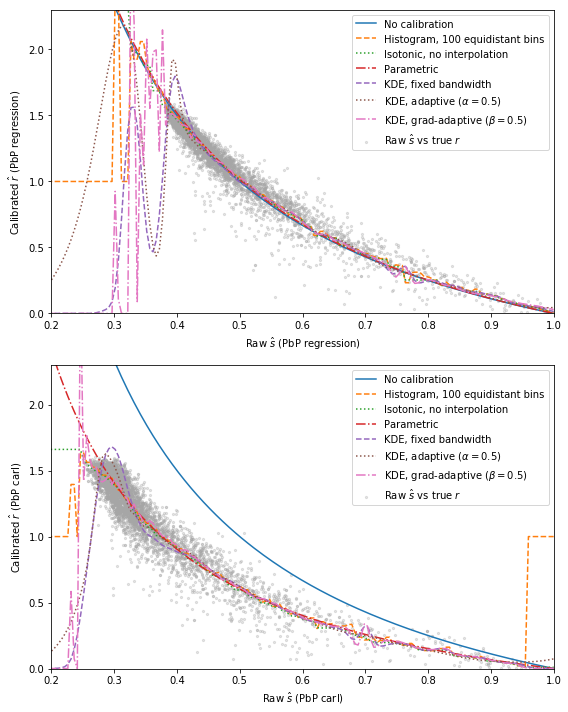

In [29]:
show_indices = [0,3,17,20,21,23,27]
linestyles=(['-'] + ['--',':','-.'] * 5)[:len(show_indices)]

plt.figure(figsize=(8.,10.))



plt.subplot(2,1,1)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, r_hat_regr_calibrated_eval_list[i], ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_regr_test[::10], r_test[::10], c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $r$')

plt.xlabel('Raw $\hat{s}$ (PbP regression)')
plt.ylabel('Calibrated $\hat{r}$ (PbP regression)')
plt.legend(loc='upper right')
plt.xlim(0.2,1.)
plt.ylim(0.,2.3)



plt.subplot(2,1,2)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, r_hat_carl_calibrated_eval_list[i], ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_carl_test[::10], r_test[::10], c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $r$')

plt.xlabel('Raw $\hat{s}$ (PbP carl)')
plt.ylabel('Calibrated $\hat{r}$ (PbP carl)')
plt.legend(loc='upper right')
plt.xlim(0.2,1.)
plt.ylim(0.,2.3)



plt.tight_layout()
plt.savefig(figure_dir + '/calibration_curves.pdf')

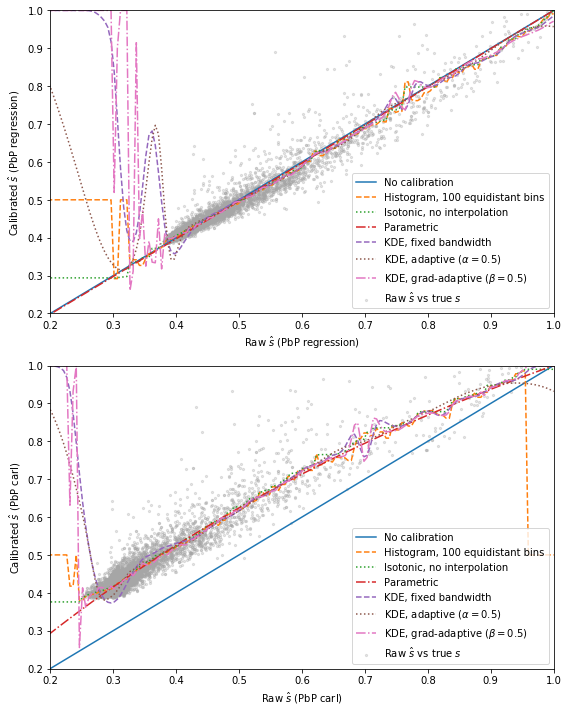

In [30]:
plt.figure(figsize=(8.,10.))



plt.subplot(2,1,1)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, s(r_hat_regr_calibrated_eval_list[i]), ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_regr_test[::10], s(r_test[::10]), c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $s$')

plt.xlabel('Raw $\hat{s}$ (PbP regression)')
plt.ylabel('Calibrated $\hat{s}$ (PbP regression)')
plt.legend(loc='lower right')
plt.xlim(0.2,1.)
plt.ylim(0.2,1.)



plt.subplot(2,1,2)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, s(r_hat_carl_calibrated_eval_list[i]),ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_carl_test[::10], s(r_test[::10]), c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $s$')

plt.xlabel('Raw $\hat{s}$ (PbP carl)')
plt.ylabel('Calibrated $\hat{s}$ (PbP carl)')
plt.legend(loc='lower right')
plt.xlim(0.2,1.)
plt.ylim(0.2,1.)



plt.tight_layout()
plt.savefig(figure_dir + '/calibration_s_curves.pdf')